Martín Amado - 19020
Juan Pablo Pineda - 19087
### Hoja de trabajo 2

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from apyori import apriori
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
pd.set_option('display.max_rows', None)

## Analisis exploratorio

In [ ]:
consumption = pd.read_excel('./CONSUMO-2022-05.xlsx', skiprows=6)
imports = pd.read_excel('./IMPORTACION-VOLUMEN-2022-05.xlsx', skiprows=6)

# Descripcion de los datos de interes

In [ ]:
interes=['Gasolina superior', 'Gasolina regular', 'Diesel']
interesF=['Fecha', 'Gasolina superior', 'Gasolina regular', 'Diesel']
consumos = consumption[interesF]
#omitimos los datos despues del 269 ya que no aportan relevancia
consumos = consumos[:269]
importes = imports[interesF]
importes = importes[:257]

In [ ]:
consumos.head(10)

In [ ]:
importes.head(10)

In [ ]:
for var in interes:
    sns.displot(consumos[var], kde=True)

In [ ]:
for var in interes:
    sns.displot(importes[var], kde=True)

In [ ]:
fechaConsumo = [pd.to_datetime(d) for d in consumos['Fecha']]
consumos['Fecha'] = fechaConsumo
fechaImportes = [pd.to_datetime(d) for d in importes['Fecha']]
importes['Fecha'] = fechaImportes

Separamos los datos en fechas 

In [ ]:
fechasC = pd.DataFrame()
fechasC['consumptionDate'] = fechaConsumo
fechasC['year'] = fechasC['consumptionDate'].dt.year
fechasC['month'] = fechasC['consumptionDate'].dt.month


fechasI = pd.DataFrame()
fechasI['consumptionDate'] = fechaImportes
fechasI['year'] = fechasI['consumptionDate'].dt.year
fechasI['month'] = fechasI['consumptionDate'].dt.month


# Pico de consumo por mes

In [ ]:
monthlyData = consumos.groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


# Pico de importaciones por mes

In [ ]:
monthlyData = importes.groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.title(x)
    plt.plot(months, monthlyData.mean()[x])
    plt.show()
    


In [ ]:
yearData = consumos.groupby(consumos['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Consumos por año por tipo de gasolina')
plt.legend()
plt.show()


In [ ]:
yearData = importes.groupby(importes['Fecha'].dt.year)
years = []
for name, group in yearData:
    years.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(years, yearData.mean()[x], label=x)

plt.title('Importaciones por año por tipo de gasolina')
plt.legend()
plt.show()


# Comportamiento de importaciones en 2020

In [ ]:
monthlyData = importes.where(importes['Fecha'].dt.year == 2020).groupby(importes['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de importaciones en 2020')
plt.legend()    
plt.show()

# Comportamiento de consumos en 2020

In [ ]:
monthlyData = consumos.where(consumos['Fecha'].dt.year == 2020).groupby(consumos['Fecha'].dt.month)
months = []
for name, group in monthlyData:
    months.append(name)

figure = plt.figure()
figure.set_figwidth(15)
figure.set_figheight(15)
for x in interes:
    plt.plot(months, monthlyData.mean()[x], label=x)

plt.title('Comportamiento de consumos en 2020')
plt.legend()    
plt.show()

### Serie de tiempo

In [ ]:
for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(consumos['Fecha'], consumos[x], label="consumos")
    plt.title(f'Consumos {x}')
    plt.show()

for x in interes:
    figure = plt.figure()
    figure.set_figwidth(15)
    figure.set_figheight(15)
    plt.plot(importes['Fecha'], importes[x], label="Importaciones")
    plt.title(f'Importaciones {x}')
    plt.show()

# Separacion para entrenamiento (Consumo Diesel)

In [ ]:
trainSize = int(len(consumos) * 0.7)
trainConsumos = consumos[0:trainSize]
testConsumos = consumos[trainSize:len(consumos)]
trainConsumos = trainConsumos.set_index(['Fecha'])
testConsumos = testConsumos.set_index(['Fecha'])

In [ ]:
tsDiesel = trainConsumos['Diesel']
mediaMovil = tsDiesel.rolling(window=12).mean()
deMovil = tsDiesel.rolling(window=12).std()

In [ ]:
original = plt.plot(tsDiesel, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

In [ ]:
descomposicion = seasonal_decompose(tsDiesel)
descomposicion.plot()

La serie parece no ser estacionaria en media ni varianza debido a la tendencia observada

## Estimacion

In [ ]:
tsDiesel = tsDiesel.astype({'Diesel':'float'})
tsDieselLog = np.log(tsDiesel)
plt.plot(tsDieselLog)

Se realiza una transformacion logaritmica

## Dickey Fuller

In [ ]:
dfTest = adfuller(tsDiesel, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

El p-value es mayor a 0.05 por lo que se realizara una diferenciacion

## Resultados del Test de Dickey Fuller para una diferenciación de serie

In [ ]:
tsDieselDiff = tsDiesel.diff()
tsDieselDiff.dropna(inplace=True)
dfTest = adfuller(tsDieselDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

El p-value es menor a 0.05, por lo que solo una diferenciacion es necesaria

In [ ]:
plt.plot(tsDieselDiff)
plt.title('Diferenciacion de la serie')

In [ ]:
plt.plot(tsDieselLog.diff())

### Estimacion de parametros del modelo

In [ ]:
tsDieselLogDiff = tsDieselLog.diff()
tsDieselLogDiff.dropna(inplace = True)
tsd_acf = acf(tsDieselLogDiff,nlags=5,fft=False)
tsd_pacf = pacf(tsDieselLogDiff, nlags=36)
tsd_acf

In [ ]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(tsDieselLogDiff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(tsDieselLogDiff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

### PACF

In [ ]:
plt.subplot(121)
plt.plot(pacf(tsDieselLogDiff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(tsDieselLogDiff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

En los graficos anteriores, se obtienen los siguientes valores

    p = 1, q = 1
    p = 1, q = 1

Y se tiene que d = 1

## ARIMA

### Prueba de estacionalidad

In [ ]:
plt.plot(acf(tsDieselLogDiff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Se observa estacionalidad aproximadamente cada doce meses (6, 18, 30)

In [ ]:
tsDieselD = tsDieselLog.diff(12)
tsDieselD.dropna(inplace=True)

In [ ]:
plt.plot(pacf(tsDieselD, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsDieselLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Se anula despues de 3
P = 3
D = 1
Q = 0

### Analisis de residuos

In [ ]:
modelo111 = SARIMAX(tsDieselLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

In [ ]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
modelo211 = SARIMAX(tsDieselLog, order=(2,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
resultado_m211.summary().tables[1]

In [ ]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [ ]:
plt.show()
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)

El modelo 111 es mejor porque en ambos el valor es menor

In [ ]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumos.set_index('Fecha')
consumoIndexed = consumoIndexed['Diesel']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred

# Separacion para entrenamiento (Consumo Regular)

In [52]:
tsRegular = trainConsumos['Gasolina regular']
mediaMovil = tsRegular.rolling(window=12).mean()
deMovil = tsRegular.rolling(window=12).std()

In [ ]:
original = plt.plot(tsRegular, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

In [ ]:
descomposicion = seasonal_decompose(tsRegular)
descomposicion.plot()

La serie parece no ser estacionaria en media ni varianza debido a la tendencia observada

## Estimacion

In [ ]:
tsRegular = tsRegular.astype({'Gasolina regular':'float'})
tsRegularLog = np.log(tsRegular)
plt.plot(tsRegularLog)

Se realiza una transformacion logaritmica

## Dickey Fuller

In [ ]:
dfTest = adfuller(tsRegular, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Valor Crítico (%s)'%key] = value
print(salidaDf)

El p-value es mayor a 0.05 por lo que se realizara una diferenciacion

## Resultados del Test de Dickey Fuller para una diferenciación de serie

In [ ]:
tsRegularDiff = tsRegular.diff()
tsRegularDiff.dropna(inplace=True)
dfTest = adfuller(tsRegularDiff)
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
salidaDf

El p-value es menor a 0.05, por lo que solo una diferenciacion es necesaria

In [ ]:
plt.plot(tsRegularDiff)
plt.title('Diferenciacion de la serie')

In [ ]:
plt.plot(tsRegularLog.diff())

### Estimacion de parametros del modelo

In [64]:
tsRegularLogDiff = tsRegularLog.diff()
tsRegularLogDiff.dropna(inplace = True)
tsd_acf = acf(tsRegularLogDiff,nlags=5,fft=False)
tsd_pacf = pacf(tsRegularLogDiff, nlags=36)
tsd_acf

array([ 1.        , -0.41486854, -0.16764322,  0.16525503, -0.04782708,
        0.12524124])

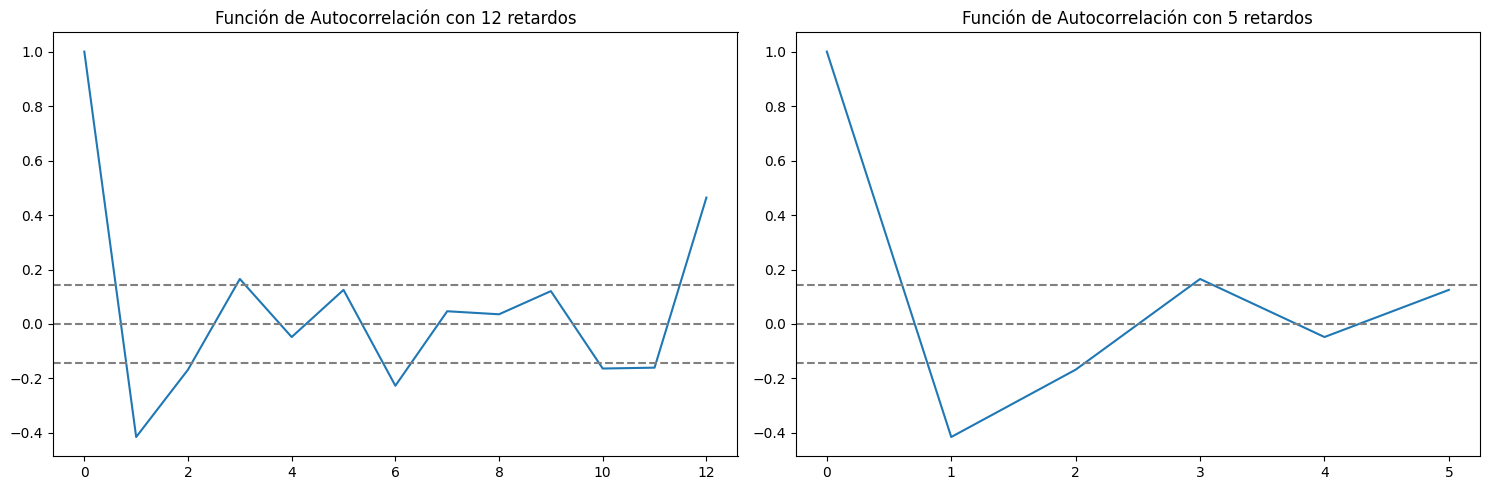

In [65]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(tsRegularLogDiff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(tsRegularLogDiff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

### PACF

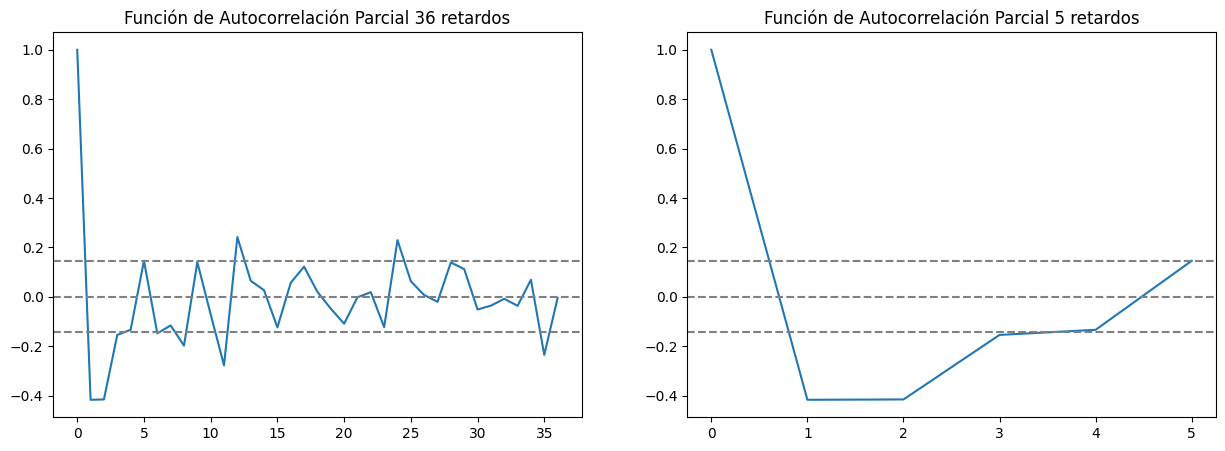

In [67]:
plt.subplot(121)
plt.plot(pacf(tsRegularLogDiff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(tsRegularLogDiff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 

En los graficos anteriores, se obtienen los siguientes valores

    p = 1, q = 1
    p = 1, q = 1

Y se tiene que d = 1

## ARIMA

### Prueba de estacionalidad

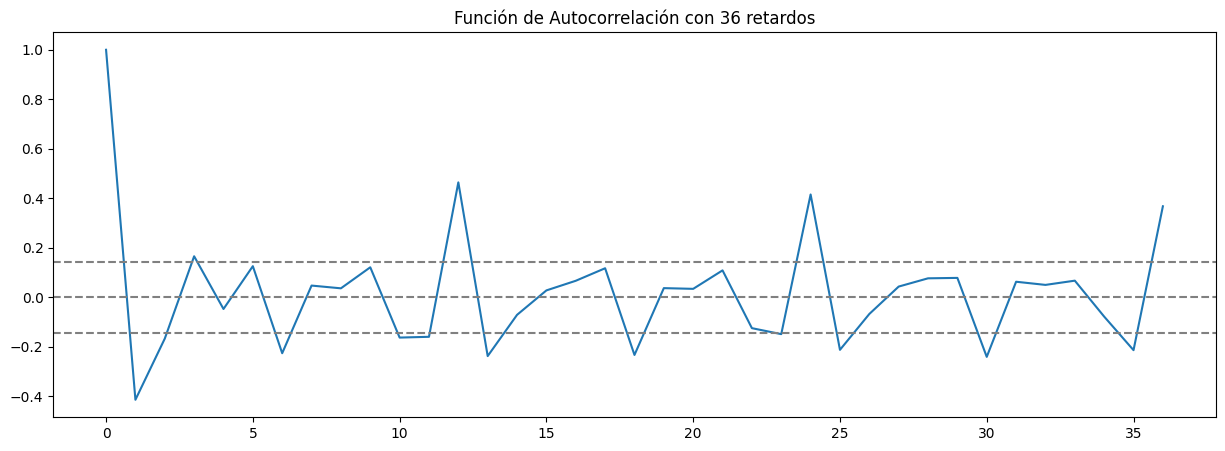

In [69]:
plt.plot(acf(tsRegularLogDiff,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

Se observa estacionalidad aproximadamente cada doce meses (12, 24, 36)

In [71]:
tsRegularD = tsRegularLog.diff(12)
tsRegularD.dropna(inplace=True)

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

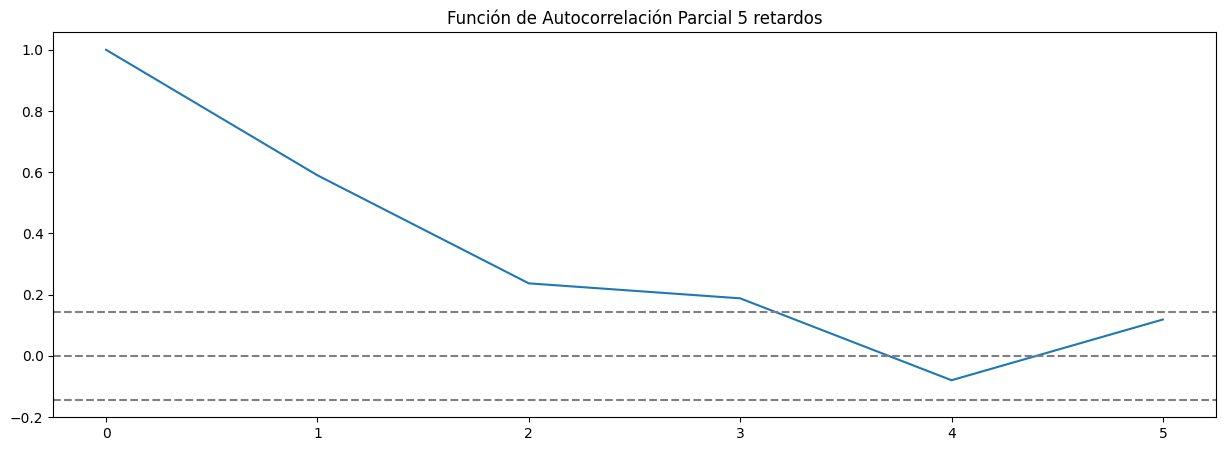

In [72]:
plt.plot(pacf(tsRegularD, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(tsRegularLogDiff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

Se anula despues de 3
P = 3
D = 1
Q = 0

### Analisis de residuos

In [ ]:
modelo111 = SARIMAX(tsRegularLog, order=(1,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = modelo111.fit()
resultado_m111.summary().tables[1]

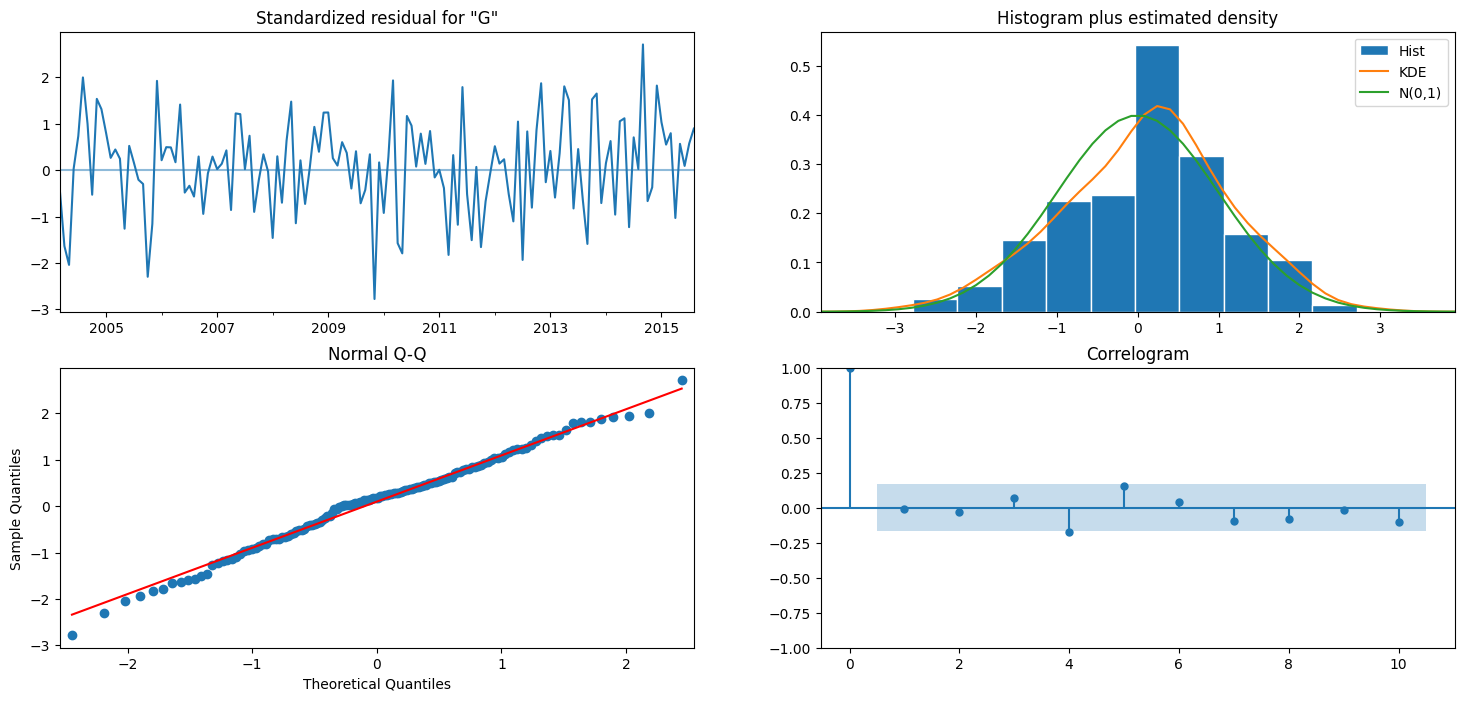

In [74]:
resultado_m111.plot_diagnostics(figsize=(18, 8))
plt.show()

In [75]:
modelo211 = SARIMAX(tsRegularLog, order=(2,1,1), seasonal_order=(3,1,0,12), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = modelo211.fit()
resultado_m211.summary().tables[1]

C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\reque\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,coef,std err,z,P>|z|,[0.025,0.975]
ar.L1,-1.1079,0.156,-7.090,0.000,-1.414,-0.802
ar.L2,-0.5020,0.078,-6.452,0.000,-0.654,-0.350
ma.L1,0.6134,0.179,3.420,0.001,0.262,0.965
ar.S.L12,-0.7503,0.078,-9.605,0.000,-0.903,-0.597
ar.S.L24,-0.5221,0.108,-4.831,0.000,-0.734,-0.310
ar.S.L36,-0.3282,0.094,-3.502,0.000,-0.512,-0.144
sigma2,0.0054,0.001,7.295,0.000,0.004,0.007


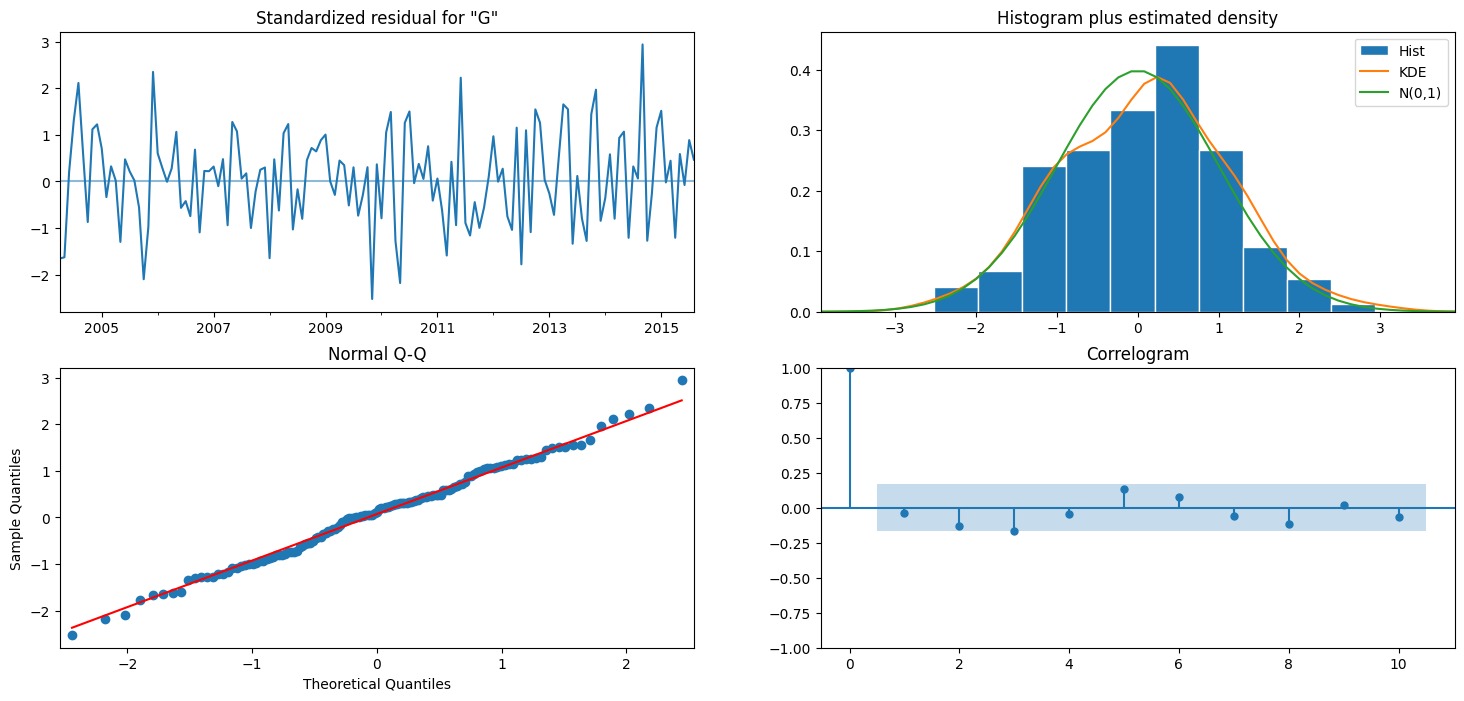

In [76]:
resultado_m211.plot_diagnostics(figsize=(18, 8))
plt.show()

In [77]:
plt.show()
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= -316.3600032463943
Modelo 211= -313.1639208165508
Resultados de BIC (Bayesian information criterion)
Modelo 111= -298.7964811354511
Modelo 211= -292.7240543357539


El modelo 111 es mejor porque en ambos el valor es menor

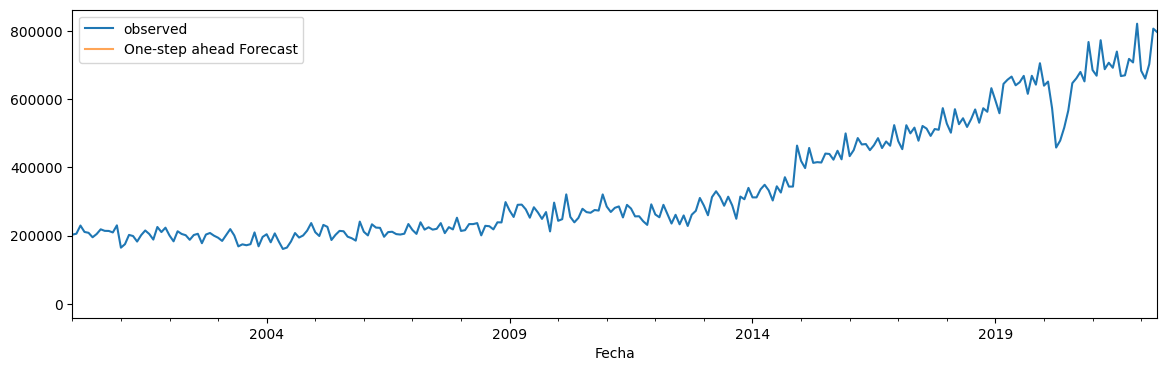

In [79]:
testConsumos.index[0]
pred = resultado_m111.get_prediction(start=testConsumos.index[0], dynamic=False)
pred_ci = pred.conf_int()
consumoIndexed = consumos.set_index('Fecha')
consumoIndexed = consumoIndexed['Gasolina regular']
ax = consumoIndexed['2000':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
#ax.set_xlabel('Date')
#ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

pred